# Reto del Titanic

## 1.Preprocesamiento de los datos

Esta primera parte esta dedicada a cargar las librerías necesarias, las bases de datos, manipulación de las bases (eliminación de variables irrelevantes, completar valores missing, entre otros). 

In [496]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Machine Learning
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.ensemble import (RandomForestClassifier,
                              StackingClassifier)
from sklearn.metrics import (accuracy_score,
                             recall_score,
                             f1_score, precision_score,
                             plot_confusion_matrix,
                             roc_curve, auc,
                             classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

import missingno as msno
from fancyimpute import KNN
from fancyimpute import IterativeImputer

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore",
                        category=sklearn.exceptions.UndefinedMetricWarning)

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
#di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

# This line will hide code by default when the notebook is exported as HTML
#di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


Lectura de los datos de entrenamiento y de validación

In [497]:
data = pd.read_csv("DATA/train.csv",na_values='.')
test = pd.read_csv("DATA/test.csv", na_values='.')
pid = test.PassengerId

Pequeña descripción estadística de la base de datos de entrenamiento

In [498]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Se considera que el nombre no aporta ninguna decisión sustancial dado que solamente sirve como identificador y esa función la cumple perfectamente la variable (PassengerID), por tanto, se elimina de la base de datos. Por otra parte, también la variable (Ticket) tiene valores unicos que no aportan nadal modelo, se elimina también. Se eliminan en las dos bases de datos (entrenamiento y testeo). 

In [499]:
# columnas a eliminar: La de nombres (3) y la del Ticket (8): No nos interesan. 
name_data = data.columns[3]
ticket_data = data.columns[8]

name_test = test.columns[2]
ticket_test = test.columns[7]

data = data.drop([name_data, ticket_data], axis=1)
test = test.drop([name_test, ticket_test], axis=1)

data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329
Cabin,204,147,G6,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Análisis de reemplazo de las variables vacias: 

Se puede notar que existen espacios vacios por la fila de Count.  Por tal razón, se debe hacer ingenieria de parámetros para poder rellenar los espacios en blanco y asi poder entrenar con seguridad los modelos. Como salida se obtienen tres bases de datos. Primero se identifica las variables que contienen valores vacios. 

Se utiliza la paquetería "missingno" y "fancyimpute" el cual facilita la imputación de los datos faltantes. 

Según la literatura, se deben evaluar las razones para la existencia de los valores missing. Pueden ocurrir tres situaciones: 


<ul>
<li>Missing Completely at Random (MCAR): Los datos faltantes existan por razones completamente aleatoria. </li>
<li>Missing at Random (MAR): Los datos faltantes existan por razones aleatorias, sin embargo, se lográ observar una relación en sentido débil entre los atributos. </li>
<li>Missing Not at Random (MNAR): Los datos faltantes existan por atributos que estén correlacionados entre sí.</li>
</ul>
 

Una forma de encontrar si los atributos de los datos faltantes están correlacionados es realizando una matriz de correlaciones y un mapa "dendograma" . Luego se escoge el método de imputación. La calidad de las imputaciones puede verificarse graficando las distribuciones de las variables missing y no missing, o corriendo regresiones lineales.

Como resultado de este apartado se obtienen cuatro bases de datos: 

<ol>
<li>data</li>
<li>data</li>
<li>Cheese</li>
<li>Cheese</li>
</ol>

Los datos originales queda guardada en un objeto que se llama data_orginal. 

Ahora se evidencia la cantidad de valores vacios en la base de datos de entrenamiento y validacion

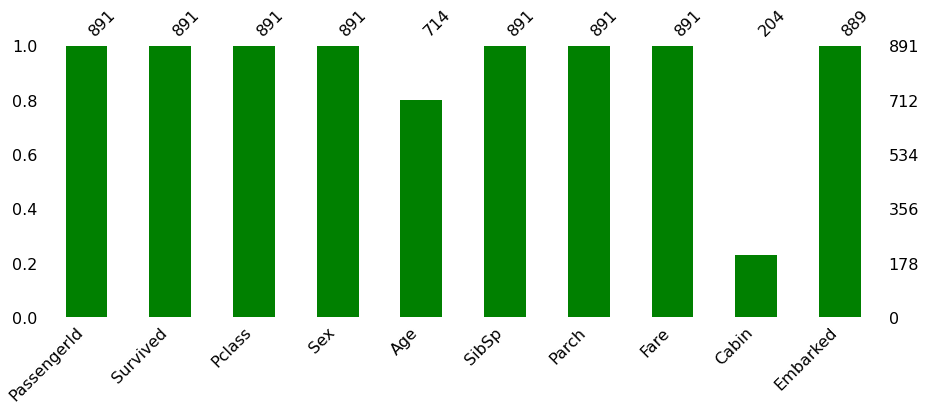

In [500]:
msno.bar(data, color="green", figsize=(15, 5))

Para tener una visión general de la base de datos se hace un plot de las variables notando la relación de vacios en relación con la orden de los datos

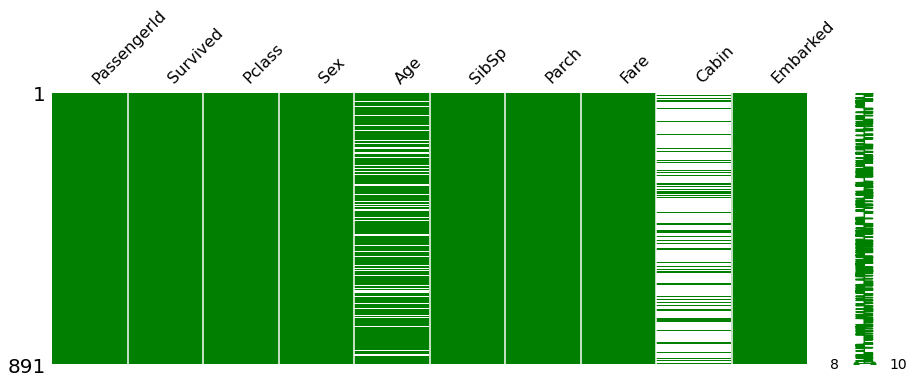

In [501]:
msno.matrix(data, color=(0.0, 0.5, 0.0), figsize=(15, 5))

Para ver si existe alguna relación se ordena los datos teniendo como referencia la variabla **Cabin**, de esta manera ver si existe a simple vista algún tipo de correlación entre **Age** y **Cabin**

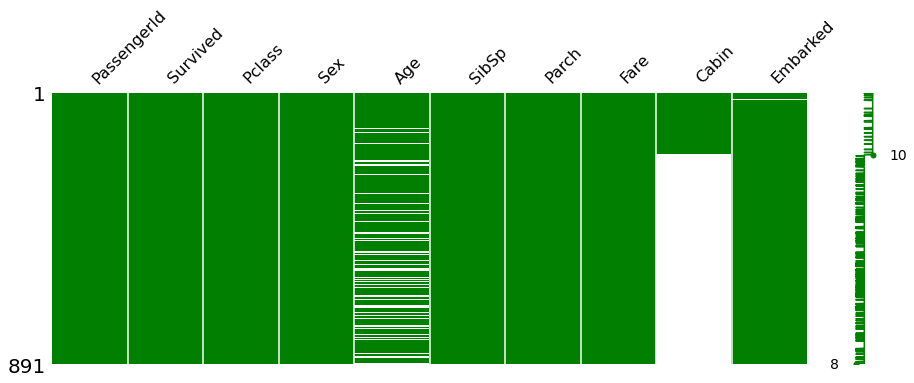

In [502]:
data_ordenada=data.sort_values("Cabin") #Se evalua si ordenando por Cabin existe alguna relación entre los missing. 
msno.matrix(data_ordenada, color=(0.0, 0.5, 0.0), figsize=(15, 5)) #Alguna relación entre cabin y Age, parece que si pero es demasiado débil, sigue siendo aleatorio. 
#msno.heatmap(data_ordenada)
#msno.dendrogram(data_ordenada) #Diagrama de arbol para datos faltantes, describe la correlación de las variables faltantes. 



Pero para confirmar 

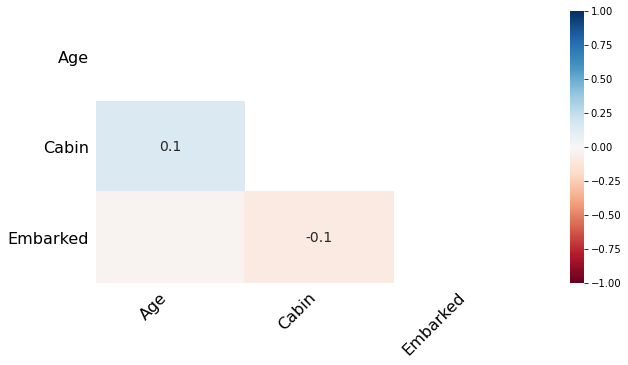

In [503]:
msno.heatmap(data, figsize=(10,5))


### Imputación en la base de entrenamiento 

#### Valores originales 

In [504]:
data_original=data.copy(deep=True)
test_original=test.copy(deep=True)

#### Imputación arbitraria

Se hace una propuesta para rellenar los espacios vacios considerando eel promedio si es una variable continua y la moda si es una variable categórica

In [505]:
data_arb = data_original.copy(deep=True)
test_arb = test_original.copy(deep=True)

# se replaza los valores de age con el promedio. 
data_arb["Age"].fillna(value=round(data_arb.Age.mean()), inplace=True)
test_arb["Age"].fillna(value=round(test_arb.Age.mean()), inplace=True)

# Se reemplaza los valores vacios por U, elección arbitraria
data_arb.Cabin.fillna(value="U", inplace=True)
test_arb.Cabin.fillna(value="U", inplace=True)

# por utlimo la variable embarked tiene 2 posiciones vacias las reemplazamos
# arbitrariamente con S, aunque puede ser a elección
data_arb["Embarked"].fillna(value="S", inplace=True)

# Para test se rellena con el promedio de datos en la variables Fare
test_arb["Fare"].fillna(test_arb.Fare.mean(), inplace=True)


#### 2. Imputación de acuerdo a la moda:

In [506]:
data_mode = data_original.copy(deep=True)
mode_imputer = SimpleImputer(strategy="most_frequent") # Create mode imputer object
data_mode.iloc[:, :] = mode_imputer.fit_transform(data_mode) # Impute using most frequent value in the DataFrame mode_imputer

test_mode = test_original.copy(deep=True)
mode_imputer = SimpleImputer(strategy="most_frequent") # Create mode imputer object
test_mode.iloc[:, :] = mode_imputer.fit_transform(test_mode) # Impute using most frequent value in the testFrame mode_imputer

#Se crea función para devolver la función get_dummys:  
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df


#### 3. Imputación por k-means


In [507]:
data_knn_imputed = data_original.copy(deep=True)
data_knn_imputed=pd.get_dummies(data_knn_imputed)
knn_imputer = KNN()
data_knn_imputed.iloc[:, :] = knn_imputer.fit_transform(data_knn_imputed) # Impute using fit_tranform on diabetes_knn_imputed
data_knn_imputed = undummify(data_knn_imputed)

test_knn_imputed = test_original.copy(deep=True)
test_knn_imputed=pd.get_dummies(test_knn_imputed)
knn_imputer = KNN()
test_knn_imputed.iloc[:, :] = knn_imputer.fit_transform(test_knn_imputed) # Impute using fit_tranform on diabetes_knn_imputed
test_knn_imputed = undummify(test_knn_imputed)

#4. Imputación por IterativeImputer: 
from fancyimpute import IterativeImputer

data_mice_imputed = data_original.copy(deep=True)
data_mice_imputed=pd.get_dummies(data_mice_imputed)
mice_imputer = IterativeImputer()
data_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(data_mice_imputed)
data_mice_imputed = undummify(data_mice_imputed)

test_mice_imputed = test_original.copy(deep=True)
test_mice_imputed=pd.get_dummies(test_mice_imputed)
mice_imputer = IterativeImputer()
test_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(test_mice_imputed)
test_mice_imputed = undummify(test_mice_imputed)



Imputing row 1/891 with 0 missing, elapsed time: 0.905
Imputing row 101/891 with 0 missing, elapsed time: 0.907
Imputing row 201/891 with 0 missing, elapsed time: 0.910
Imputing row 301/891 with 1 missing, elapsed time: 0.911
Imputing row 401/891 with 0 missing, elapsed time: 0.913
Imputing row 501/891 with 0 missing, elapsed time: 0.915
Imputing row 601/891 with 0 missing, elapsed time: 0.917
Imputing row 701/891 with 0 missing, elapsed time: 0.919
Imputing row 801/891 with 0 missing, elapsed time: 0.920
Imputing row 1/418 with 0 missing, elapsed time: 0.117
Imputing row 101/418 with 0 missing, elapsed time: 0.119
Imputing row 201/418 with 1 missing, elapsed time: 0.121
Imputing row 301/418 with 0 missing, elapsed time: 0.123
Imputing row 401/418 with 0 missing, elapsed time: 0.125


#### 4. Imputación por IterativeImputer

In [509]:
data_mice_imputed = data_original.copy(deep=True)
data_mice_imputed=pd.get_dummies(data_mice_imputed)
mice_imputer = IterativeImputer()
data_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(data_mice_imputed)
data_mice_imputed = undummify(data_mice_imputed)

test_mice_imputed = test_original.copy(deep=True)
test_mice_imputed=pd.get_dummies(test_mice_imputed)
mice_imputer = IterativeImputer()
test_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(test_mice_imputed)
test_mice_imputed = undummify(test_mice_imputed)


Se guardan las bases de datos que se rellenaron por los diferentes métodos

In [510]:
data_arb.to_csv("DATA/data_arb.csv", index=False)
data_mode.to_csv("DATA/data_mode.csv", index=False)
data_knn_imputed.to_csv("DATA/data_knn_imputed.csv", index=False)
data_mice_imputed.to_csv("DATA/data_mice_imputed.csv", index=False)


Ahora se construye el modelo pero teniendo diferentes fuentes de datos de entrenamiento, que se propusieron anteriormente

# Modelo

En este modelo se incluyen cuatro clasificadores para contruir un metamodelo que será el modelo definitivo en la propuesta de reolución del problema, estos modelos son:

* Clasificador Bayesiano Ingenuo (Bernoulli)
* Clasificador Arbol de decisión
* Regresión logística
* Clasificador Random Forest

El metamodelo se construye a partir de un **StackingClassifier**



Ahora se hace un analisis de la base de datos para poder tener un mejor conjunto de entrenamiento. Para esto se hace análisis entre características y la variable objetivo, es decir, si es un sobreviviente o no. La primera variable que se quiere tratar es la edad de los pasajeros, el siguiente diagrama muestra como se distribuye las edades de los sobrevivientes. El eje $x$ representa la edad de los pasajeros y el eje $y$ el conteo por edad. 

Esto se hace para cada base de datos 

In [511]:
Data = [data_arb, data_mode, data_knn_imputed, data_mice_imputed]
Data_test = [test_arb, test_mode, test_knn_imputed, test_mice_imputed]

#### Imputación arbitaria

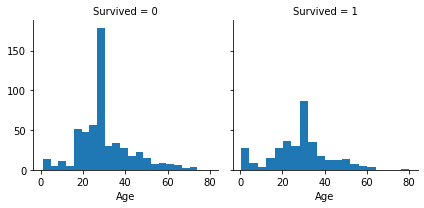

In [512]:
g = sns.FacetGrid(data_arb, col='Survived')
g.map(plt.hist, 'Age', bins=20)

#### Imputación por moda

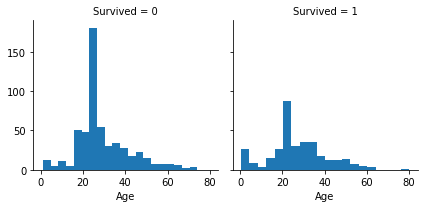

In [513]:
g = sns.FacetGrid(data_mode, col='Survived')
g.map(plt.hist, 'Age', bins=20)

#### Imputación por K-means

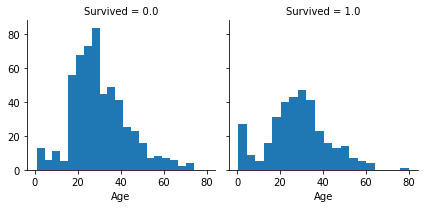

In [514]:
g = sns.FacetGrid(data_knn_imputed, col='Survived')
g.map(plt.hist, 'Age', bins=20)

#### Imputacion iterativa

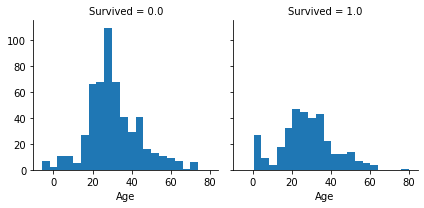

In [515]:
g = sns.FacetGrid(data_mice_imputed, col='Survived')
g.map(plt.hist, 'Age', bins=20)

dado que se ve es esta sesgado los datos podemos hacer grupos que agrupen diferentes rangos de edades para agrupar las personas por edades. Esto se hace para cada base de datos con diferente imputación  

In [516]:
for dataset in Data:
    dataset["Age_group"] = pd.cut(dataset["Age"],5)
    print(dataset[["Age_group", "Survived"]].groupby(["Age_group"], as_index=False).mean().sort_values(by="Age_group", ascending=True))

          Age_group  Survived
0    (0.34, 16.336]  0.550000
1  (16.336, 32.252]  0.344168
2  (32.252, 48.168]  0.404255
3  (48.168, 64.084]  0.434783
4    (64.084, 80.0]  0.090909
          Age_group  Survived
0    (0.34, 16.336]  0.550000
1  (16.336, 32.252]  0.344168
2  (32.252, 48.168]  0.404255
3  (48.168, 64.084]  0.434783
4    (64.084, 80.0]  0.090909
          Age_group  Survived
0    (0.34, 16.336]  0.548077
1  (16.336, 32.252]  0.353070
2  (32.252, 48.168]  0.372000
3  (48.168, 64.084]  0.428571
4    (64.084, 80.0]  0.090909
          Age_group  Survived
0   (-6.099, 11.19]  0.520000
1   (11.19, 28.392]  0.398329
2  (28.392, 45.595]  0.342697
3  (45.595, 62.797]  0.406977
4    (62.797, 80.0]  0.200000


Ahora se reemplaza en las bases de datos de entrenamiento y testeo


In [517]:
for j in range(len(Data)):
    for dataset in [Data[j], Data_test[j]]:
        dataset.loc[dataset["Age"] <= 16, "Age"] = 0
        dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
        dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
        dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3

# Se borra la columna auxiliar para la construcción de los grupos
for i in range(len(Data)):
    Data[i] = Data[i].drop(["Age_group"], axis=1)



Ahora se hace una compactificación de las características utilizando el número de heramanos/conyuges *SibSp* y el número de padres/hijos *Parch*. Se crea una nueva columna en la base de datos para tal propuesta

In [518]:
for j in range(len(Data)):
    Data[j]["FamilySize"] = Data[j]["SibSp"] + Data[j]["Parch"] + 1
    Data_test[j]["FamilySize"] = Data_test[j]["SibSp"] + Data_test[j]["Parch"] + 1


In [519]:
Data[0][['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


La propuesta es ver si una persona que estuviera sola en el barco tenía más opción de salvarse que otra que tuviera algún tipo de lazo familiar , para esto se introduce una nueva variable que se llamará "Alone", y se indexarán las tres columnas *SibSp*, *Parch* y *FamilySize* en la nueva columna *Alone* 

In [520]:
for j in range(len(Data)):
    Data[j]["Alone"] = 0
    Data[j].loc[Data[j]["FamilySize"] == 1, "Alone"] = 1
    Data_test[j]["Alone"] = 0
    Data_test[j].loc[Data_test[j]["FamilySize"] == 1, "Alone"] = 1

Data[0][['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean()

,Alone,Survived
0,0,0.505650
1,1,0.303538


Borramos las variables que se utilizaron y no se quieren tener para el entrenamiento 

In [521]:
for i in range(len(Data)):
    Data[i] = Data[i].drop(["Parch", "SibSp", "FamilySize"], axis =1)
    Data_test[i] = Data_test[i].drop(["Parch", "SibSp", "FamilySize"], axis =1)


In [522]:
print(np.shape(Data[0]))
print(np.shape(Data_test[0]))

(891, 9)
(418, 8)


Variables para el modelo

In [523]:
X = []
y =[]
for dataset in Data:
    x = dataset.drop(["Survived"], axis=1)
    X.append(x)
    y.append(dataset["Survived"])

In [524]:
print(np.shape(X[0]))
print(np.shape(Data_test[0]))

(891, 8)
(418, 8)


Existen en la base de datos variables categoricas que deben codificarse, para este caso se utiliza la codificación más simple, variables dummy. Se utiliza matrices de numpy para poder llamar la clase OneHotEncoder de scikit learn, que permite codificar las variables de la base de datos de entrenamiento

In [525]:
enc = []
for i in range(len(X)):
    X[i] = X[i].to_numpy()
    y[i] = y[i].to_numpy()
    enc.append(OneHotEncoder(handle_unknown="ignore"))
    enc[i].fit(X[i])
    X[i] = enc[i].transform(X[i]).toarray()

separación de datos en conjuntos de validación y entrenamiento 

In [526]:
X_train = []
X_test = []
y_train = []
y_test = []

for i in range(len(X)):
    aux = train_test_split(X[i], y[i], test_size=0.2, random_state=11)
    X_train.append(aux[0])
    X_test.append(aux[1])
    y_train.append(aux[2])
    y_test.append(aux[3])


### Optimización de hiperparámetros de los modelos 

Para la optimización de parámetros se utiliza *GridSearchCV* un clase disponible en scikit-learn que permite evaluar y seleccionar de forma sistemática los parámetros de determinado modelo. La facilidad es que se puede manejar el rango de hiperparámetros que se quiere probar y asi evaluar los adecuados para obtener el mejor rendimiento mediante validación cruzada.  

Para construir el metamodelo se deben elegir de la manera más óptima los hiperparámetros de cada sub modelo, esta propuesta se hace con la intención de tener el mayor rendimiento en las métricas que se usarán

In [527]:
# variable de reproducibilidad
seed = 11

# Métricas a utilizar
scoring = {"Accuracy": "accuracy",
           "f1_Score": "f1",
           "Precision": "precision",
           "Recall": "recall"}

#### Arbol de decisión (Hiperparámetros)

In [528]:
parametros_decision_tree = {"max_depth": np.arange(1, 30)}
model_desicion_tree = DecisionTreeClassifier(class_weight='balanced',
                                             random_state=seed
                                             )
model_desicion_tree = GridSearchCV(model_desicion_tree,
                                   parametros_decision_tree,
                                   cv=5,
                                   scoring=scoring,
                                   refit="Accuracy"
                                   )
max_depth_DT = []
for i in range(len(X)):
    model_desicion_tree.fit(X_train[i], y_train[i])
    print("Nombre modelo: ", type(model_desicion_tree).__name__)
    print("Mejores parametros: {}".format(model_desicion_tree.best_params_))
    print("Mejor puntaje: {:.2f}".format(model_desicion_tree.best_score_))
    print(" ")

    max_depth_DT.append(model_desicion_tree.best_params_["max_depth"])

Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 23}
Mejor puntaje: 0.80
 
Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 14}
Mejor puntaje: 0.80
 
Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 25}
Mejor puntaje: 0.79
 
Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 21}
Mejor puntaje: 0.80
 


#### Bosque Aleatorio (Hiperparámetros)

In [529]:
parametros_Random_forest = {"n_estimators": np.arange(1, 15),
                            "max_depth": np.arange(1, 15),
                            "max_samples": np.arange(1, 15)}
model_random_forest = RandomForestClassifier(bootstrap=True,
                                             ccp_alpha=0.0,
                                             criterion="entropy",
                                             random_state=seed
                                             )
model_random_forest = GridSearchCV(model_random_forest,
                                   parametros_Random_forest,
                                   cv=5,
                                   scoring=scoring,
                                   refit="Accuracy")
n_estimators_RF = []
max_depth_RF = []
max_samples_RF = []
for i in range(len(X)):
    model_random_forest.fit(X_train[i], y_train[i])
    print("Nombre modelo: ", type(model_random_forest).__name__)
    print("Mejores parametros: {}".format(model_random_forest.best_params_))
    print("Mejor puntaje: {:.2f}".format(model_random_forest.best_score_))
    print(" ")

    n_estimators_RF.append(model_random_forest.best_params_["n_estimators"])
    max_depth_RF.append(model_random_forest.best_params_["max_depth"])
    max_samples_RF.append(model_random_forest.best_params_["max_samples"])

Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 7, 'max_samples': 13, 'n_estimators': 14}
Mejor puntaje: 0.76
 
Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 5, 'max_samples': 12, 'n_estimators': 13}
Mejor puntaje: 0.74
 
Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 4, 'max_samples': 7, 'n_estimators': 10}
Mejor puntaje: 0.72
 
Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 3, 'max_samples': 8, 'n_estimators': 5}
Mejor puntaje: 0.71
 


#### Metamodelo

In [530]:
# Metamodelo para cada una de las imputaciones 
clfs = []

for i in range(len(X)):
    clfs.append([("Bernoulli", BernoulliNB(alpha=0.8)),
            ("Arbol Decision", DecisionTreeClassifier(max_depth=max_depth_DT[i],
                                                      class_weight="balanced",
                                                      random_state=seed)),
            ("LR", LogisticRegression(solver="liblinear",
                                      class_weight="balanced",
                                      random_state=seed)),
            ("Forest", RandomForestClassifier(bootstrap=True,
                                              criterion="entropy",
                                              max_depth=max_depth_RF[i],
                                              n_estimators=n_estimators_RF[i],
                                              max_samples=max_samples_RF[i],
                                              random_state=seed))])
clf = []
pred_test = []
imputacion = ["Arbitraria", "Moda", "KNN", "Iterativa"]
for i in range(len(X)):
    clf.append(StackingClassifier(estimators=clfs[i],
                         final_estimator=LogisticRegression(),
                         cv=10,
                         stack_method="auto",
                         n_jobs=-1,
                         passthrough=True))

    clf[i].fit(X_train[i], y_train[i])
    pred_test.append(clf[i].predict(X_test[i]))
    print(imputacion[i])
    print("Name: ", type(clf[i]).__name__)
    print(" ")
    print("test Accuracy: {:.2f}".format(accuracy_score(y_test[i], pred_test[i])))
    print(" ")
    print('Recall test: {:.2f}'.format(recall_score(y_test[i], pred_test[i])))
    print(" ")
    print('F1-Score test: {:.2f}'.format(f1_score(y_test[i], pred_test[i])))
    print(" ")
    print('Precision test: {:.2f}'.format(precision_score(y_test[i], pred_test[i])))
    print(" ")


Arbitraria
Name:  StackingClassifier
 
test Accuracy: 0.89
 
Recall test: 0.80
 
F1-Score test: 0.83
 
Precision test: 0.86
 
Moda
Name:  StackingClassifier
 
test Accuracy: 0.90
 
Recall test: 0.82
 
F1-Score test: 0.85
 
Precision test: 0.88
 
KNN
Name:  StackingClassifier
 
test Accuracy: 0.89
 
Recall test: 0.79
 
F1-Score test: 0.83
 
Precision test: 0.87
 
Iterativa
Name:  StackingClassifier
 
test Accuracy: 0.91
 
Recall test: 0.82
 
F1-Score test: 0.86
 
Precision test: 0.91
 


##### Matriz de Confusion del modelo 

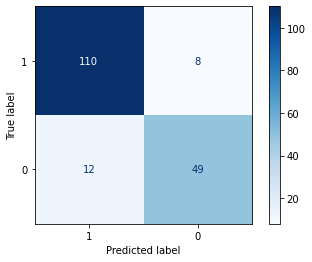

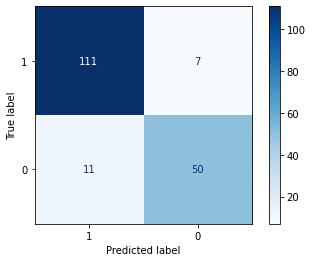

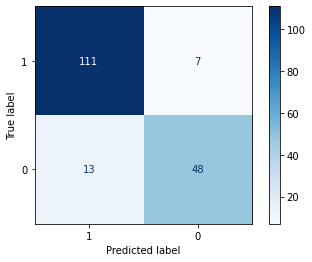

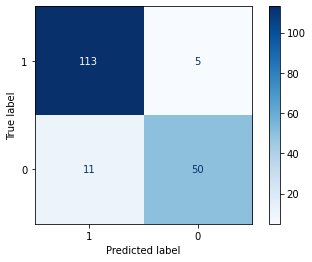

In [531]:
for i in range(len(X)):
    plot_confusion_matrix(clf[i], X_test[i],
                          y_test[i], cmap="Blues",
                          display_labels=[1,0])
    plt.savefig("Metamodelo_"+imputacion[i])

In [532]:
for i in range(len(X)):
    print(imputacion[i])
    print(classification_report(y_test[i],pred_test[i]))

Arbitraria
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       118
           1       0.86      0.80      0.83        61

    accuracy                           0.89       179
   macro avg       0.88      0.87      0.87       179
weighted avg       0.89      0.89      0.89       179

Moda
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       118
           1       0.88      0.82      0.85        61

    accuracy                           0.90       179
   macro avg       0.89      0.88      0.89       179
weighted avg       0.90      0.90      0.90       179

KNN
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       118
         1.0       0.87      0.79      0.83        61

    accuracy                           0.89       179
   macro avg       0.88      0.86      0.87       179
weighted avg       0.89      0.89      0.89       179


Construcción resultado para someter al sistema Kaggle

In [535]:
test_encode = enc[3].transform(Data_test[3]).toarray()
output = pd.DataFrame({"PassengerID": pid,
                       "Survived": clf[i].predict(test_encode)})
output.to_csv("submission.csv", index=False)

# Modelo 2 :

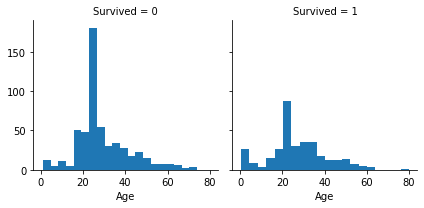

In [46]:
g = sns.FacetGrid(data_mode, col='Survived')
g.map(plt.hist, 'Age', bins=20)

data_mode["Age_group"] = pd.cut(data_mode["Age"],5)
data_mode[["Age_group", "Survived"]].groupby(["Age_group"], as_index=False).mean().sort_values(by="Age_group", ascending=True)

for dataset in [data_mode, test_mode]:
    dataset.loc[dataset["Age"] <= 16, "Age"] = 0
    dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
    dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
    dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3

# Se borra la columna auxiliar para la construcción de los grupos
data_mode = data_mode.drop(["Age_group"], axis=1)
data_mode.head(10)

for dataset in [data_mode, test_mode]:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
    

data_mode[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

for dataset in [data_mode, test_mode]:
    dataset["Alone"] = 0
    dataset.loc[dataset["FamilySize"] == 1, "Alone"] = 1

data_mode = data_mode.drop(["Parch", "SibSp", "FamilySize"], axis =1)
test_mode = test_mode.drop(["Parch", "SibSp", "FamilySize"], axis =1)

data_mode[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean()

Survival = data_mode.columns[1]
X = data_mode.drop([Survival], axis=1)
y = data_mode[Survival]
X.columns

X = X.to_numpy()
Y = y.to_numpy()
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
X = enc.transform(X).toarray()


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)


Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 23}
Mejor puntaje: 0.80
 
Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 5, 'max_samples': 12, 'n_estimators': 13}
Mejor puntaje: 0.74
 
Name:  StackingClassifier
 
test Accuracy: 0.90
 
Recall test: 0.79
 
F1-Score test: 0.84
 
Precision test: 0.91
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       118
           1       0.91      0.79      0.84        61

    accuracy                           0.90       179
   macro avg       0.90      0.87      0.88       179
weighted avg       0.90      0.90      0.90       179



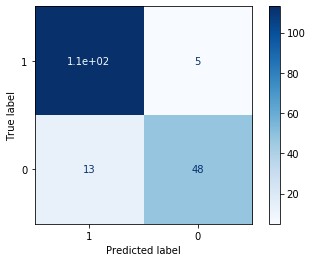

In [47]:
# variable de reproducibilidad
seed = 11

# Métricas a utilizar
scoring = {"Accuracy": "accuracy",
           "f1_Score": "f1",
           "Precision": "precision",
           "Recall": "recall"}

parametros_decision_tree = {"max_depth": np.arange(1, 30)}
model_desicion_tree = DecisionTreeClassifier(class_weight='balanced',
                                             random_state=seed
                                             )
model_desicion_tree = GridSearchCV(model_desicion_tree,
                                   parametros_decision_tree,
                                   cv=5,
                                   scoring=scoring,
                                   refit="Accuracy"
                                   )
model_desicion_tree.fit(X_train, y_train)
print("Nombre modelo: ", type(model_desicion_tree).__name__)
print("Mejores parametros: {}".format(model_desicion_tree.best_params_))
print("Mejor puntaje: {:.2f}".format(model_desicion_tree.best_score_))
print(" ")

max_depth_DT = model_desicion_tree.best_params_["max_depth"]


parametros_Random_forest = {"n_estimators": np.arange(1, 15),
                            "max_depth": np.arange(1, 15),
                            "max_samples": np.arange(1, 15)}
model_random_forest = RandomForestClassifier(bootstrap=True,
                                             ccp_alpha=0.0,
                                             criterion="entropy",
                                             random_state=seed
                                             )
model_random_forest = GridSearchCV(model_random_forest,
                                   parametros_Random_forest,
                                   cv=5,
                                   scoring=scoring,
                                   refit="Accuracy")
model_random_forest.fit(X_train, y_train)
print("Nombre modelo: ", type(model_random_forest).__name__)
print("Mejores parametros: {}".format(model_random_forest.best_params_))
print("Mejor puntaje: {:.2f}".format(model_random_forest.best_score_))
print(" ")

n_estimators_RF = model_random_forest.best_params_["n_estimators"]
max_depth_RF = model_random_forest.best_params_["max_depth"]
max_samples_RF = model_random_forest.best_params_["max_samples"]

clfs = [("Bernoulli", BernoulliNB(alpha=0.8)),
        ("Arbol Decision", DecisionTreeClassifier(max_depth=max_depth_DT,
                                                  class_weight="balanced",
                                                  random_state=seed)),
        ("LR", LogisticRegression(solver="liblinear",
                                  class_weight="balanced",
                                  random_state=seed)),
        ("Forest", RandomForestClassifier(bootstrap=True,
                                          criterion="entropy",
                                          max_depth=max_depth_RF,
                                          n_estimators=n_estimators_RF,
                                          max_samples=max_samples_RF,
                                          random_state=seed))]

clf = StackingClassifier(estimators=clfs,
                         final_estimator=LogisticRegression(),
                         cv=10,
                         stack_method="auto",
                         n_jobs=-1,
                         passthrough=True)


clf.fit(X_train, y_train)
pred_test = clf.predict(X_test)
print("Name: ", type(clf).__name__)
print(" ")
print("test Accuracy: {:.2f}".format(accuracy_score(y_test, pred_test)))
print(" ")
print('Recall test: {:.2f}'.format(recall_score(y_test, pred_test)))
print(" ")
print('F1-Score test: {:.2f}'.format(f1_score(y_test, pred_test)))
print(" ")
print('Precision test: {:.2f}'.format(precision_score(y_test, pred_test)))

plot_confusion_matrix(clf, X_test,
                      y_test, cmap="Blues",
                      display_labels=[1,0])
plt.savefig("Metamodelo")

print(classification_report(y_test,pred_test))

In [ ]:
# Modelo 3: 

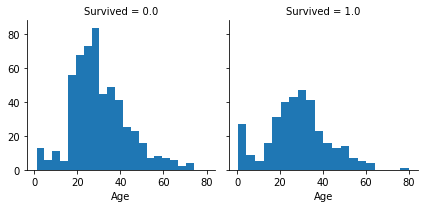

In [48]:
g = sns.FacetGrid(data_knn_imputed, col='Survived')
g.map(plt.hist, 'Age', bins=20)

data_knn_imputed["Age_group"] = pd.cut(data_knn_imputed["Age"],5)
data_knn_imputed[["Age_group", "Survived"]].groupby(["Age_group"], as_index=False).mean().sort_values(by="Age_group", ascending=True)

for dataset in [data_knn_imputed, test_knn_imputed]:
    dataset.loc[dataset["Age"] <= 16, "Age"] = 0
    dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
    dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
    dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3

# Se borra la columna auxiliar para la construcción de los grupos
data_knn_imputed = data_knn_imputed.drop(["Age_group"], axis=1)
data_knn_imputed.head(10)

for dataset in [data_knn_imputed, test_knn_imputed]:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
    

data_knn_imputed[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

for dataset in [data_knn_imputed, test_knn_imputed]:
    dataset["Alone"] = 0
    dataset.loc[dataset["FamilySize"] == 1, "Alone"] = 1

data_knn_imputed = data_knn_imputed.drop(["Parch", "SibSp", "FamilySize"], axis =1)
test_knn_imputed = test_knn_imputed.drop(["Parch", "SibSp", "FamilySize"], axis =1)

data_knn_imputed[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean()

Survival = data_knn_imputed.columns[1]
X = data_knn_imputed.drop([Survival], axis=1)
y = data_knn_imputed[Survival]
X.columns

X = X.to_numpy()
Y = y.to_numpy()
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
X = enc.transform(X).toarray()


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)




Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 22}
Mejor puntaje: 0.79
 
Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 4, 'max_samples': 7, 'n_estimators': 10}
Mejor puntaje: 0.72
 
Name:  StackingClassifier
 
test Accuracy: 0.89
 
Recall test: 0.79
 
F1-Score test: 0.83
 
Precision test: 0.87
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       118
         1.0       0.87      0.79      0.83        61

    accuracy                           0.89       179
   macro avg       0.88      0.86      0.87       179
weighted avg       0.89      0.89      0.89       179



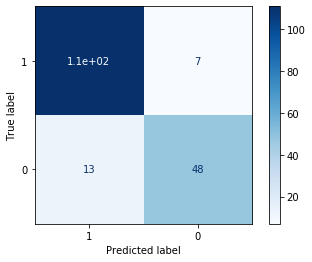

In [49]:
# variable de reproducibilidad
seed = 11

# Métricas a utilizar
scoring = {"Accuracy": "accuracy",
           "f1_Score": "f1",
           "Precision": "precision",
           "Recall": "recall"}

parametros_decision_tree = {"max_depth": np.arange(1, 30)}
model_desicion_tree = DecisionTreeClassifier(class_weight='balanced',
                                             random_state=seed
                                             )
model_desicion_tree = GridSearchCV(model_desicion_tree,
                                   parametros_decision_tree,
                                   cv=5,
                                   scoring=scoring,
                                   refit="Accuracy"
                                   )
model_desicion_tree.fit(X_train, y_train)
print("Nombre modelo: ", type(model_desicion_tree).__name__)
print("Mejores parametros: {}".format(model_desicion_tree.best_params_))
print("Mejor puntaje: {:.2f}".format(model_desicion_tree.best_score_))
print(" ")

max_depth_DT = model_desicion_tree.best_params_["max_depth"]


parametros_Random_forest = {"n_estimators": np.arange(1, 15),
                            "max_depth": np.arange(1, 15),
                            "max_samples": np.arange(1, 15)}
model_random_forest = RandomForestClassifier(bootstrap=True,
                                             ccp_alpha=0.0,
                                             criterion="entropy",
                                             random_state=seed
                                             )
model_random_forest = GridSearchCV(model_random_forest,
                                   parametros_Random_forest,
                                   cv=5,
                                   scoring=scoring,
                                   refit="Accuracy")
model_random_forest.fit(X_train, y_train)
print("Nombre modelo: ", type(model_random_forest).__name__)
print("Mejores parametros: {}".format(model_random_forest.best_params_))
print("Mejor puntaje: {:.2f}".format(model_random_forest.best_score_))
print(" ")

n_estimators_RF = model_random_forest.best_params_["n_estimators"]
max_depth_RF = model_random_forest.best_params_["max_depth"]
max_samples_RF = model_random_forest.best_params_["max_samples"]

clfs = [("Bernoulli", BernoulliNB(alpha=0.8)),
        ("Arbol Decision", DecisionTreeClassifier(max_depth=max_depth_DT,
                                                  class_weight="balanced",
                                                  random_state=seed)),
        ("LR", LogisticRegression(solver="liblinear",
                                  class_weight="balanced",
                                  random_state=seed)),
        ("Forest", RandomForestClassifier(bootstrap=True,
                                          criterion="entropy",
                                          max_depth=max_depth_RF,
                                          n_estimators=n_estimators_RF,
                                          max_samples=max_samples_RF,
                                          random_state=seed))]

clf = StackingClassifier(estimators=clfs,
                         final_estimator=LogisticRegression(),
                         cv=10,
                         stack_method="auto",
                         n_jobs=-1,
                         passthrough=True)


clf.fit(X_train, y_train)
pred_test = clf.predict(X_test)
print("Name: ", type(clf).__name__)
print(" ")
print("test Accuracy: {:.2f}".format(accuracy_score(y_test, pred_test)))
print(" ")
print('Recall test: {:.2f}'.format(recall_score(y_test, pred_test)))
print(" ")
print('F1-Score test: {:.2f}'.format(f1_score(y_test, pred_test)))
print(" ")
print('Precision test: {:.2f}'.format(precision_score(y_test, pred_test)))

plot_confusion_matrix(clf, X_test,
                      y_test, cmap="Blues",
                      display_labels=[1,0])
plt.savefig("Metamodelo")

print(classification_report(y_test,pred_test))

In [ ]:
# Modelo 4: 

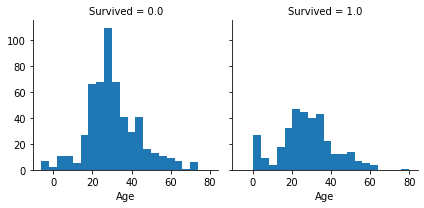

In [70]:
g = sns.FacetGrid(data_mice_imputed, col='Survived')
g.map(plt.hist, 'Age', bins=20)

data_mice_imputed["Age_group"] = pd.cut(data_mice_imputed["Age"],5)
data_mice_imputed[["Age_group", "Survived"]].groupby(["Age_group"], as_index=False).mean().sort_values(by="Age_group", ascending=True)

for dataset in [data_mice_imputed, test_mice_imputed]:
    dataset.loc[dataset["Age"] <= 16, "Age"] = 0
    dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
    dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
    dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3

# Se borra la columna auxiliar para la construcción de los grupos
data_mice_imputed = data_mice_imputed.drop(["Age_group"], axis=1)
data_mice_imputed.head(10)

for dataset in [data_mice_imputed, test_mice_imputed]:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
    

data_mice_imputed[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

for dataset in [data_mice_imputed, test_mice_imputed]:
    dataset["Alone"] = 0
    dataset.loc[dataset["FamilySize"] == 1, "Alone"] = 1

data_mice_imputed = data_mice_imputed.drop(["Parch", "SibSp", "FamilySize"], axis =1)
test_mice_imputed = test_mice_imputed.drop(["Parch", "SibSp", "FamilySize"], axis =1)

data_mice_imputed[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean()

Survival = data_mice_imputed.columns[1]
X = data_mice_imputed.drop([Survival], axis=1)
y = data_mice_imputed[Survival]
X.columns

X = X.to_numpy()
Y = y.to_numpy()
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
X = enc.transform(X).toarray()


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=11)



Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 25}
Mejor puntaje: 0.80
 
Nombre modelo:  GridSearchCV
Mejores parametros: {'max_depth': 3, 'max_samples': 8, 'n_estimators': 5}
Mejor puntaje: 0.71
 
Name:  StackingClassifier
 
test Accuracy: 0.90
 
Recall test: 0.79
 
F1-Score test: 0.84
 
Precision test: 0.91
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       118
         1.0       0.91      0.79      0.84        61

    accuracy                           0.90       179
   macro avg       0.90      0.87      0.88       179
weighted avg       0.90      0.90      0.90       179



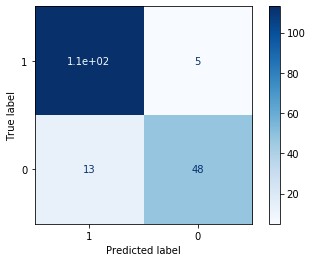

In [71]:
# variable de reproducibilidad
seed = 11

# Métricas a utilizar
scoring = {"Accuracy": "accuracy",
           "f1_Score": "f1",
           "Precision": "precision",
           "Recall": "recall"}

parametros_decision_tree = {"max_depth": np.arange(1, 30)}
model_desicion_tree = DecisionTreeClassifier(class_weight='balanced',
                                             random_state=seed
                                             )
model_desicion_tree = GridSearchCV(model_desicion_tree,
                                   parametros_decision_tree,
                                   cv=5,
                                   scoring=scoring,
                                   refit="Accuracy"
                                   )
model_desicion_tree.fit(X_train, y_train)
print("Nombre modelo: ", type(model_desicion_tree).__name__)
print("Mejores parametros: {}".format(model_desicion_tree.best_params_))
print("Mejor puntaje: {:.2f}".format(model_desicion_tree.best_score_))
print(" ")

max_depth_DT = model_desicion_tree.best_params_["max_depth"]


parametros_Random_forest = {"n_estimators": np.arange(1, 15),
                            "max_depth": np.arange(1, 15),
                            "max_samples": np.arange(1, 15)}
model_random_forest = RandomForestClassifier(bootstrap=True,
                                             ccp_alpha=0.0,
                                             criterion="entropy",
                                             random_state=seed
                                             )
model_random_forest = GridSearchCV(model_random_forest,
                                   parametros_Random_forest,
                                   cv=5,
                                   scoring=scoring,
                                   refit="Accuracy")
model_random_forest.fit(X_train, y_train)
print("Nombre modelo: ", type(model_random_forest).__name__)
print("Mejores parametros: {}".format(model_random_forest.best_params_))
print("Mejor puntaje: {:.2f}".format(model_random_forest.best_score_))
print(" ")

n_estimators_RF = model_random_forest.best_params_["n_estimators"]
max_depth_RF = model_random_forest.best_params_["max_depth"]
max_samples_RF = model_random_forest.best_params_["max_samples"]

clfs = [("Bernoulli", BernoulliNB(alpha=0.8)),
        ("Arbol Decision", DecisionTreeClassifier(max_depth=max_depth_DT,
                                                  class_weight="balanced",
                                                  random_state=seed)),
        ("LR", LogisticRegression(solver="liblinear",
                                  class_weight="balanced",
                                  random_state=seed)),
        ("Forest", RandomForestClassifier(bootstrap=True,
                                          criterion="entropy",
                                          max_depth=max_depth_RF,
                                          n_estimators=n_estimators_RF,
                                          max_samples=max_samples_RF,
                                          random_state=seed))]

clf = StackingClassifier(estimators=clfs,
                         final_estimator=LogisticRegression(),
                         cv=10,
                         stack_method="auto",
                         n_jobs=-1,
                         passthrough=True)


clf.fit(X_train, y_train)
pred_test = clf.predict(X_test)
print("Name: ", type(clf).__name__)
print(" ")
print("test Accuracy: {:.2f}".format(accuracy_score(y_test, pred_test)))
print(" ")
print('Recall test: {:.2f}'.format(recall_score(y_test, pred_test)))
print(" ")
print('F1-Score test: {:.2f}'.format(f1_score(y_test, pred_test)))
print(" ")
print('Precision test: {:.2f}'.format(precision_score(y_test, pred_test)))

plot_confusion_matrix(clf, X_test,
                      y_test, cmap="Blues",
                      display_labels=[1,0])
plt.savefig("Metamodelo")

print(classification_report(y_test,pred_test))